In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install tensorflow_federated

In [ ]:
# 1. Import libraries
import os
import glob
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [ ]:
# 2. ---------------------- Config ----------------------

#SEQ_LENGTH = 24
BATCH_SIZE = 32
#WEEK_HOURS = 168
#DATA_DIR = "/content/drive/MyDrive/thesis_timeseries/data"  # Path to .pkl files
EPOCHS = 3
ONE_YEAR_HOURS = 8760  # 365 * 24
# test_data = 2190

In [ ]:
def load_and_split(file_path, train_ratio=0.7, val_ratio=0.15):
    '''
    1. Data Loading and Preprocessing
    2. Data Splitting and Scaling
    3. Splitting into train and validation data
    4. Sequence Creation and Weekly Batching
    '''
    df = pd.read_pickle(file_path)

    if len(df) > ONE_YEAR_HOURS:
        df = df[-ONE_YEAR_HOURS:]

    df = df[['kwh', 'm3h']].astype(np.float32)

    # Split
    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train, val, test = df[:train_end], df[train_end:val_end], df[val_end:]


    # MinMax Scale
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)

    return train_scaled, val_scaled, test_scaled, scaler


In [ ]:
def create_multistep_sequences(data, n_input, n_output, stride=1):
    X, y = [], []
    for i in range(0, len(data) - n_input - n_output + 1, stride):
        X.append(data[i:i + n_input, 0:2]) # inputs: both kwh and m3h
        y.append(data[i + n_input:i + n_input + n_output, 0])  # target: kwh
    return np.array(X), np.array(y)

In [ ]:
# n_input = SEQ_Length

def build_model(n_input, n_features, n_output):

    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=(n_input, n_features)),
        # First layer - 128 units
        tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Second layer - 64 units
        tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Second layer - 32 units
        tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.001), recurrent_dropout = 0.2),
        tf.keras.layers.GroupNormalization(),

        # Fully connected layet
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        # Drop out
        tf.keras.layers.Dropout(0.3),
        # Output layer
        tf.keras.layers.Dense(n_output)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [ ]:
import matplotlib.pyplot as plt

def run_for_client(file_path, client_name, n_input=168, n_output=24, stride=1):
    # Load and split
    train, val, test, scaler = load_and_split(file_path)

    # Prepare sequences
    X_train, y_train = create_multistep_sequences(train, n_input, n_output, stride)
    X_val, y_val     = create_multistep_sequences(val, n_input, n_output, stride)
    X_test, y_test   = create_multistep_sequences(test, n_input, n_output, stride)

    # Build and train
    model = build_model(n_input, train.shape[1], n_output)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

    # Forecast last window from test
    last_input = X_test[-1].reshape(1, n_input, train.shape[1])
    pred_scaled = model.predict(last_input)
    predicted = scaler.inverse_transform(
        np.hstack([pred_scaled.T, np.zeros((n_output, train.shape[1]-1))])
    )[:, 0]

    # Actual future values
    actual = scaler.inverse_transform(
        np.hstack([y_test[-1].reshape(-1,1), np.zeros((n_output, train.shape[1]-1))])
    )[:, 0]

    # Plot
    plt.plot(range(n_output), actual, label='Actual')
    plt.plot(range(n_output), predicted, label='Forecast', linestyle='--')
    plt.title(f"Client: {client_name} - 24-Hour Forecast")
    plt.xlabel("Hour Ahead")
    plt.ylabel("kwh")
    plt.legend()
    plt.show()


Epoch 1/3
186/186 [==============================] - 150s 755ms/step - loss: 0.0772 - mae: 0.0749 - val_loss: 0.0105 - val_mae: 0.0593
Epoch 2/3
186/186 [==============================] - 140s 754ms/step - loss: 0.0092 - mae: 0.0703 - val_loss: 0.0055 - val_mae: 0.0620
Epoch 3/3
1/1 [==============================] - 1s 891ms/step


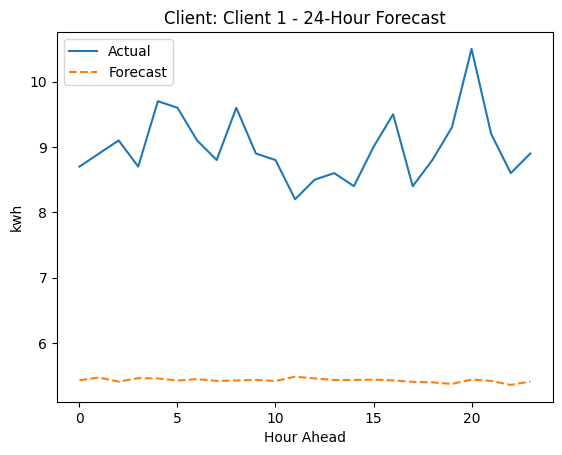

Epoch 1/3
186/186 [==============================] - 146s 732ms/step - loss: 0.0734 - mae: 0.0548 - val_loss: 0.0115 - val_mae: 0.0592
Epoch 2/3
186/186 [==============================] - 134s 721ms/step - loss: 0.0069 - mae: 0.0549 - val_loss: 0.0061 - val_mae: 0.0568
Epoch 3/3
1/1 [==============================] - 1s 843ms/step


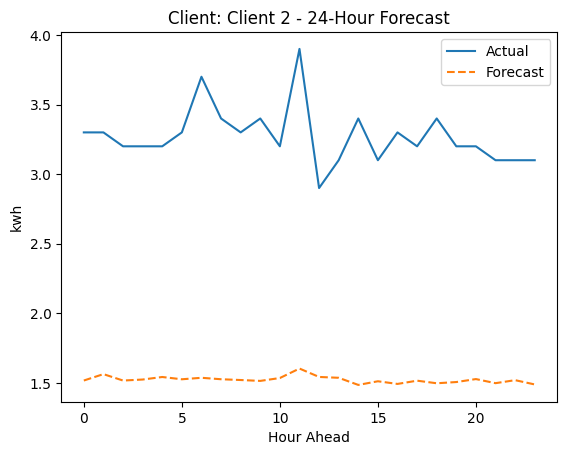

Epoch 1/3
186/186 [==============================] - 145s 737ms/step - loss: 0.0749 - mae: 0.0581 - val_loss: 0.0079 - val_mae: 0.0384
Epoch 2/3
186/186 [==============================] - 134s 719ms/step - loss: 0.0040 - mae: 0.0244 - val_loss: 0.0019 - val_mae: 0.0273
Epoch 3/3
1/1 [==============================] - 1s 823ms/step


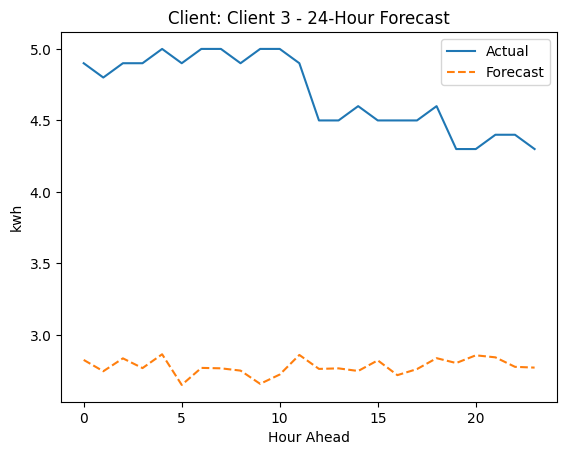

In [ ]:
DATA_DIR = "/content/drive/MyDrive/thesis_timeseries/data"  # Path to .pkl files

run_for_client(os.path.join(DATA_DIR, "695645.pkl"), "Client 1")
run_for_client(os.path.join(DATA_DIR, "695947.pkl"), "Client 2")
run_for_client(os.path.join(DATA_DIR, "696204.pkl"), "Client 3")
